<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "VLMC-Pia"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/Level3-SubCellType/VLMC-Pia/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


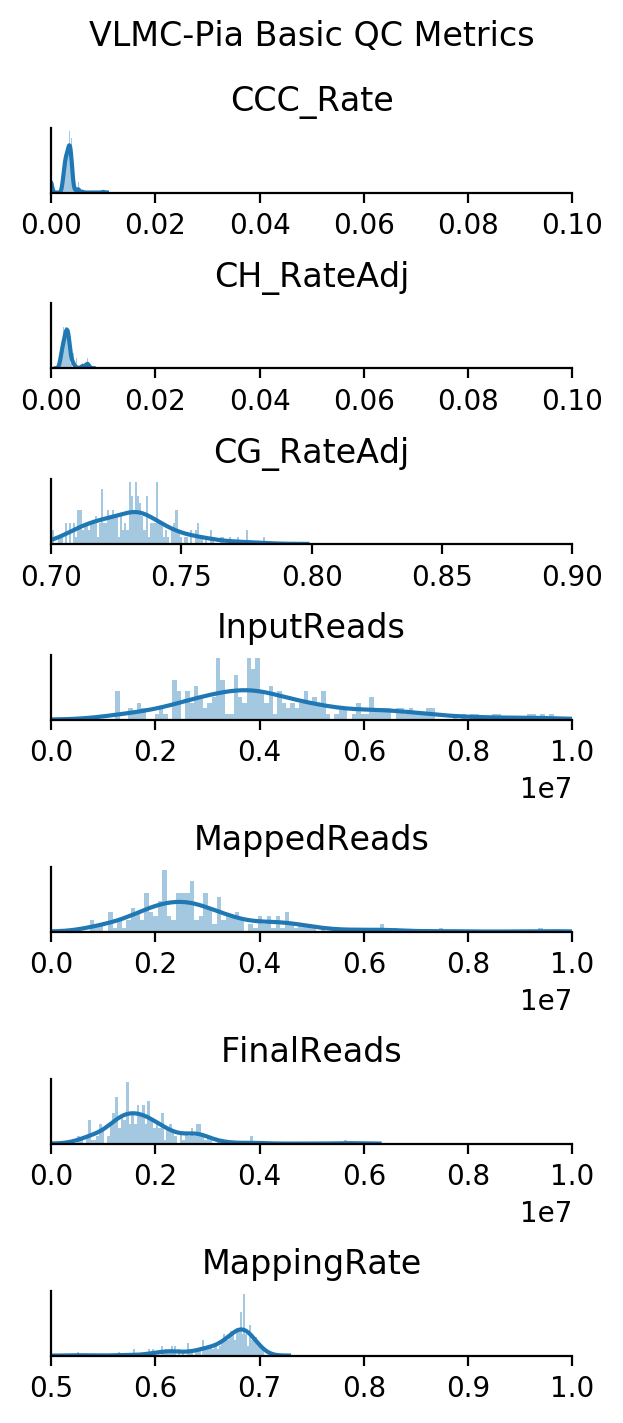

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

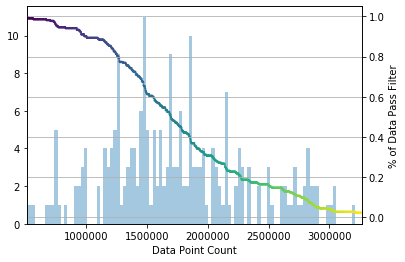

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 225/225 (100.0%)
CG_RateAdj passed 225/225 (100.0%)
CH_RateAdj passed 225/225 (100.0%)
FinalReads passed 225/225 (100.0%)
MappingRate passed 225/225 (100.0%)
Overall passed 225/225 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
171206 3
171212 2
171213 1
171219 1
180104 1
180109 1
180119 4
180122 1
180123 1
180206 2
180208 3
180212 6
180222 1
180226 7
180227 7
180305 3
180306 1
180312 1
180313 3
180319 3
180320 18
180326 13
180329 15
180402 5
180403 5
180405 1
180409 9
180410 8
180412 3
180416 5
180417 5
180419 7
180423 2
180424 2
180426 1
180430 2
180514 1
180529 5
180806 2
181002 5
181008 5
181009 12
181022 1
181023 2
181204 2
181210 4
181218 1
190108 1
190117 1
190122 6
190131 9
190205 4
190214 2
190219 1
190305 3
190307 1
190627 1
190711 1
190716 2


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 36 9.4%
ad002 25 6.5%
ad004 35 9.1%
ad006 25 6.5%
ad007 31 8.1%
ad008 22 5.7%
ad010 26 6.8%
ad012 25 6.5%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l1-umap_0,l1-umap_1,l1-tsne_0,l1-tsne_1,MajorType,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,PassFilter
cell,,,,,,,,,,,,,,,,,,,,,
10E_M_2553,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.003818,0.731619,0.730590,0.006802,0.002996,2141788.0,6135656,3990743.0,10E,...,-24.411915,4.547135,-39.326882,20.255156,VLMC-Pia,7.559937,3.397658,-37.863056,-4.002392,True
11E_M_1264,/gale/raidix/rdx-4/mapping/11E/CEMBA190214-11E...,0.003563,0.716644,0.715631,0.006663,0.003111,1756764.0,4230358,2898405.0,11E,...,-24.666203,4.857295,-39.172145,19.760853,VLMC-Pia,6.598211,1.999891,-32.610730,-8.940993,True
11E_M_2022,/gale/raidix/rdx-4/mapping/11E/CEMBA190305-11E...,0.003053,0.707928,0.707033,0.005766,0.002721,1486002.0,3629398,2481485.0,11E,...,-23.891644,4.872487,-38.377223,20.199828,VLMC-Pia,6.723005,2.538621,-33.514945,-6.299712,True
11E_M_2578,/gale/raidix/rdx-4/mapping/11E/CEMBA190305-11E...,0.004155,0.733983,0.732873,0.007369,0.003227,1331964.0,3218770,1820034.0,11E,...,-24.168468,4.393315,-39.322537,20.682279,VLMC-Pia,7.450697,3.253974,-37.871676,-3.982100,True
11E_M_2774,/gale/raidix/rdx-4/mapping/11E/CEMBA190305-11E...,0.003943,0.680811,0.679548,0.006163,0.002228,1447557.0,3793760,2375819.0,11E,...,-24.639971,4.927505,-39.310030,19.558771,VLMC-Pia,6.443262,1.861935,-32.212152,-9.050435,True
11E_M_982,/gale/raidix/rdx-4/mapping/11E/CEMBA190214-11E...,0.003503,0.684293,0.683184,0.006831,0.003339,1562177.0,3814140,2615712.0,11E,...,-25.022562,4.292451,-40.474899,19.963246,VLMC-Pia,7.038340,1.999814,-33.566122,-9.471586,True
1A_M_108,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.002540,0.739910,0.739250,0.004720,0.002190,1167286.0,2767388,1861418.0,1A,...,-23.982706,4.254754,-39.128807,21.253130,VLMC-Pia,8.457027,2.963955,-39.257531,-6.669687,True
1A_M_1133,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.002340,0.714360,0.713690,0.004080,0.001740,2821469.0,5824704,4029560.0,1A,...,-23.400208,3.687090,-39.043680,22.143466,VLMC-Pia,6.165176,3.054446,-30.807100,-4.117231,True
1A_M_1221,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.002290,0.742600,0.742010,0.004210,0.001920,921322.0,2097628,1413574.0,1A,...,-24.088257,4.556986,-38.790811,20.511626,VLMC-Pia,7.742798,2.529072,-37.083147,-6.216760,True
